#### **1. Define System**

In [13]:
from jqme import System

#### **2. Define Environment**

In [14]:
from typing import Literal
import numpy as np
from qutip import (Qobj,
                   mesolve,
                   sesolve,
                   sigmaz,
                   identity,
                   basis,
                   destroy,
                   tensor,
                   qzero,
                   )


class Environment:
    def __init__(self):
        pass

    def get_H_env(self):
        pass

    def get_H_coupl(self, system: System):
        pass


class PseudoMode(Environment):
    def __init__(self,
                 frequencies_pseudomode: float | list[float] | np.ndarray,
                 levels_pseudomode: int,
                 couplings_ep: float | list[float] | np.ndarray,
                 ):
        super().__init__()
        self.pseudomode(frequencies_pseudomode=frequencies_pseudomode,
                        levels_pseudomode=levels_pseudomode,
                        couplings_ep=couplings_ep,
                        )

    @property
    def mode_dict(self):
        return self._mode_dict

    @mode_dict.setter
    def mode_dict(self, md):
        self._mode_dict = md

    def pseudomode(self,
                   frequencies_pseudomode: float | list[float] | np.ndarray,
                   levels_pseudomode: int,
                   couplings_ep: float | list[float] | np.ndarray,
                   ):
        frequencies_pseudomode = np.atleast_1d(frequencies_pseudomode)
        levels_pseudomode = np.atleast_1d(levels_pseudomode)
        couplings_ep = np.atleast_1d(couplings_ep)
        if frequencies_pseudomode.size != levels_pseudomode.size:
            raise ValueError(
                'The number of pseudomodes and levels should be the same.')
        if frequencies_pseudomode.size != couplings_ep.size:
            raise ValueError(
                'The number of pseudomodes and couplings should be the same.')

        state_mode = self.__set_mode_state(levels_pseudomode)

        self.mode_dict = {
            'omega_mode': frequencies_pseudomode,
            'lvl_mode': levels_pseudomode,
            'coupl_ep': couplings_ep,
            'state_mode': state_mode,
        }

    def __set_mode_state(self, levels_pseudomode: np.ndarray):
        return [[1.+0.j] + [0.+0.j]*(levels-1) for levels in levels_pseudomode]

    def get_H_env(self):
        W = len(self.mode_dict['omega_mode'])
        d = list(self.mode_dict['lvl_mode'])
        Id = [identity(d[k]) for k in range(W)]
        H = qzero(dimensions=d)
        for k in range(W):
            a = destroy(d[k])
            H += (self.mode_dict['omega_mode'][k]
                  * tensor(*[Id[i] if i != k else a.dag()*a for i in range(W)]))
        return H

    def get_H_coupl(self, system: System):
        N = system.system_size
        W = len(self.mode_dict['omega_mode'])
        d = list(self.mode_dict['lvl_mode'])
        Id = [identity(d[k]) for k in range(W)]
        I = identity(2)
        sz = sigmaz()
        H = qzero(dimensions=[2]*N + d*N)
        for i in range(N):
            for k in range(W):
                a = destroy(d[k])
                H += (self.mode_dict['coupl_ep'][k]/2
                      * tensor(*[I]*(N-i-1), I-sz, *[I]*i, *Id*(N-i-1),
                               *[Id[j] if j != k else a.dag() + a for j in range(W)], *Id*i))
        return H

    def get_H_global(self, system: System):
        N = system.system_size
        W = len(self.mode_dict['omega_mode'])
        I = identity(2)
        d = list(self.mode_dict['lvl_mode'])
        Id = [identity(d[k]) for k in range(W)]
        H_sys = system.get_H_sys()
        H_env = self.get_H_env()
        H_coupl = self.get_H_coupl(system)
        H = tensor(H_sys, *Id*N) + H_coupl
        for i in range(N):
            H += tensor(*[I]*N, *Id*(N-i-1), H_env, *Id*i)
        return H

#### **3. Define evolution**

In [15]:
from typing import Literal
import numpy as np
from qutip import (Qobj,
                   mesolve,
                   sesolve,
                   sigmaz,
                   identity,
                   basis,
                   destroy,
                   tensor,
                   )


class Backend:
    def __init__(self,
                 method: Literal['classical', 'quantum'],
                 **kwargs,
                 ):
        self.method = method

    def _run(self,
             hamiltonian: Qobj,
             state: Qobj,
             time: float | list[float] | np.ndarray,
             e_ops: list[Qobj],
             c_ops: list[Qobj],
             ):
        if self.method == 'classical':
            solve = sesolve if state == 'ket' else mesolve
            return solve(hamiltonian,
                         state,
                         time,
                         e_ops=e_ops,
                         c_ops=c_ops,
                         )
        elif self.method == 'quantum':
            return self.run_quantum()

In [16]:
class Evolution:
    def __init__(self,
                 backend: Backend,
                 ):
        self.backend = backend

    def run(self,
            system: System,
            environment: Environment,
            time: float | list[float] | np.ndarray,
            rates: float | list[float] | None = None,
            ):
        if not system.is_valid:
            raise ValueError('System is not valid')
        # if not environment.is_valid:
        #     raise ValueError('Environment is not valid')

        e_ops_ = e_ops(system.system_size, basis(2, 1).proj())
        c_ops_ = (e_ops(system.system_size, np.sqrt(rates) * sigmaz())
                  if rates else [])

        results = self.backend._run(system.get_H_sys(),
                                    system.get_e_state(),
                                    time,
                                    e_ops_,
                                    c_ops_,
                                    )

        print('The evolution has been completed')
        return results


def e_ops(N, op, Id_psudomodes=None):
    I = identity(2)
    if not Id_psudomodes:
        return [tensor(*[I]*(N-i-1), op, *[I]*i) for i in range(N)]
    return [tensor(*[I]*(N-i-1), op, *[I]*i, *Id_psudomodes*N) for i in range(N)]

In [17]:
import numpy as np
from scipy.linalg import toeplitz

epsilon = [1, 2]
J = toeplitz([0, 1])

sys = System(energies=epsilon,
             couplings=J,
             )

In [18]:
print(sys.energies)
print(sys.couplings)
print(sys.dipole_moments)

[1 2]
[[0 1]
 [1 0]]
[1. 1.]


In [19]:
sys.get_H_sys()

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-1.5  0.   0.   0. ]
 [ 0.  -0.5  1.   0. ]
 [ 0.   1.   0.5  0. ]
 [ 0.   0.   0.   1.5]]

In [20]:
sys.set_state(state_type='delocalized excitation',
              state=[1/np.sqrt(2), 1/np.sqrt(2)])

sys.get_e_state()

Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[0.        ]
 [0.70710678]
 [0.70710678]
 [0.        ]]

In [21]:
sys.to_dict()

{'class': 'System',
 'is_valid': True,
 'quantities': {'energies': array([1, 2]),
  'system_size': 2,
  'couplings': array([[0, 1],
         [1, 0]]),
  'dipoles': array([1., 1.]),
  'state_type': 'delocalized excitation',
  'state': [(0.7071067811865475+0j), (0.7071067811865475+0j)]},
 'is_vaild': False}

In [22]:
frequenties_pseudomode = [0]
Gamma = np.array([2])
Omega = np.array([1])

env = PseudoMode(frequencies_pseudomode=frequenties_pseudomode,
                 levels_pseudomode=[2]*len(frequenties_pseudomode),
                 couplings_ep=np.sqrt(Gamma*Omega/2).tolist(),
                 )

print(env._mode_dict)

{'omega_mode': array([0]), 'lvl_mode': array([2]), 'coupl_ep': array([1.]), 'state_mode': [[(1+0j), 0j]]}


In [23]:
env.get_H_coupl(sys)

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]]

In [24]:
env.get_H_global(sys)

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-1.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.  -1.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.  -1.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.  -1.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.  -0.5  1.   0.   0.   1.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   1.  -0.5  0.   0.   0.   1.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -0.5  1.   0.   0.   1.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   1.  -0.5  0.   0.   0.   1.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   1.   0.   0.   0.   0.5  0.   1.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   1.   0.   0.   0.   0.5  0.   1.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   1.   0.   1.

In [25]:
dt = 0.01
time = np.arange(0, 20, dt)
shots = 16000

In [26]:
backend = Backend(method='classical')
evolution = Evolution(backend=backend)

results = evolution.run(system=sys,
                        environment=None,
                        time=time,
                        rates=0.1,
                        )

The evolution has been completed


[[<matplotlib.lines.Line2D at 0x7fcee58a52d0>],

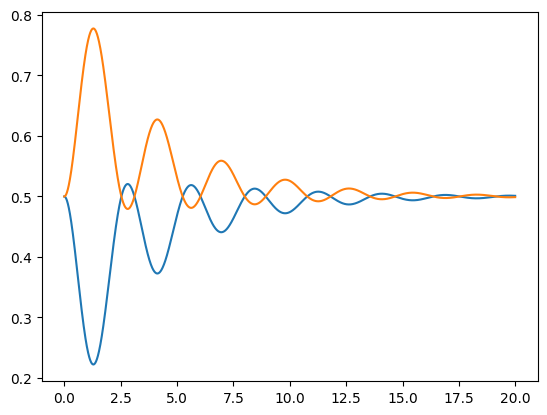

In [27]:
import matplotlib.pyplot as plt

P_qutip = results.expect
error = [np.sqrt(P_qutip[i] * (np.ones_like(P_qutip[i]) - P_qutip[i]))
         for i in range(len(epsilon))]

[plt.plot(time, P_qutip[i]) for i in range(len(epsilon))]